In [5]:
import corner
import numpy as np
import json
import matplotlib.pyplot as plt

# Frequentist
import pyhf
pyhf.set_backend('jax')

# Bayesian
import pymc
import arviz

# Both
# import Bayesian_pyhf

%load_ext autoreload
%autoreload 

In [1]:
!pip install --editable .

Obtaining file:///Users/malinhorstmann/Library/Mobile%20Documents/com~apple~CloudDocs/Documents/Bayesian_pyhf/Documenation/PyHEP23/PyHEP23
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Obtaining dependency information for pymc>=5.0.2 from https://files.pythonhosted.org/packages/45/89/341da7baee2d8e6e2654e50ebc4d1dca49c762a8a132b6cd6cb1eae1fa80/pymc-5.9.0-py3-none-any.whl.metadata
  Using cached pymc-5.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached pytensor-2.17.1-cp311-cp311-macosx_11_0_arm64.whl
Using cached pymc-5.9.0-py3-none-any.whl (469 kB)
  Building editable for Bayesian_pyhf (pyproject.toml) ... done
  Created wheel for Bayesian_pyhf: filename=bayesian_pyhf-0.1.dev4-py3-none-any.whl size=1594 sha256=bcb996b4b92f57a8c86d5f44fdd3485121bc2c21513921df8f803a2a81b7d7e6
  Stored in directory: /private/var/folders/dl/v

In [2]:
from os.path import dirname, realpath, sep, pardir
import sys
sys.path.append('/Users/malinhorstmann/Library/Mobile Documents/com~apple~CloudDocs/Documents/Bayesian_pyhf/Documenation/PyHEP23/PyHEP23/src')

from Bayesian_pyhf import infer

## Example 1: Adapted Public Likelihood
- Search for displaced leptons in $\sqrt s$ = 13 TeV $pp$ collisions with the ATLAS detector
- https://www.hepdata.net/record/resource/1981552?landing_page=true

In [6]:
with open(f'workspaces/SRee_SRmm_Srem.json') as serialized:
    workspace = pyhf.Workspace(json.load(serialized))

model = workspace.model()

observations = workspace.data(model, include_auxdata=False)
observations_inclAux = workspace.data(model)

In [7]:
model.config.poi_name

'mu_Sig'

In [8]:
unconstr_priors = {
    f'{model.config.poi_name}': {'type': 'HalfNormal_Unconstrained', 'sigma': [3]}
}

In [9]:
n_draws = 10_000

with infer.model(model, unconstr_priors, observations):
    step = pymc.Metropolis()
    
    post_data = pymc.sample(draws=n_draws, chains=1, step=step)
    post_pred = pymc.sample_posterior_predictive(post_data)
    prior_pred = pymc.sample_prior_predictive(n_draws)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [lumi]
>Metropolis: [mu_Sig]
>Metropolis: [ucbSRee]
>Metropolis: [ucbSRem]
>Metropolis: [ucbSRmm]
>Metropolis: [SigXSec]
>Metropolis: [cuts_SRmm_LRT]
>Metropolis: [cuts_SRmm_LRTfilter]
>Metropolis: [ucsSRmm_Slep_1000_10]
>Metropolis: [ucsSRmm_disp]
>Metropolis: [ucsSRmm_mu_sel]
>Metropolis: [ucsSRmm_mu_trig]
>Metropolis: [ucsSRmm_pileupWeight]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, SigXSec, cuts_SRmm_LRT, cuts_SRmm_LRTfilter, lumi, mu_Sig, ucbSRee, ucbSRem, ucbSRmm, ucsSRmm_Slep_1000_10, ucsSRmm_disp, ucsSRmm_mu_sel, ucsSRmm_mu_trig, ucsSRmm_pileupWeight]


array([[<Axes: title={'center': 'lumi'}>,
        <Axes: title={'center': 'lumi'}>],
       [<Axes: title={'center': 'mu_Sig'}>,
        <Axes: title={'center': 'mu_Sig'}>],
       [<Axes: title={'center': 'SigXSec'}>,
        <Axes: title={'center': 'SigXSec'}>]], dtype=object)

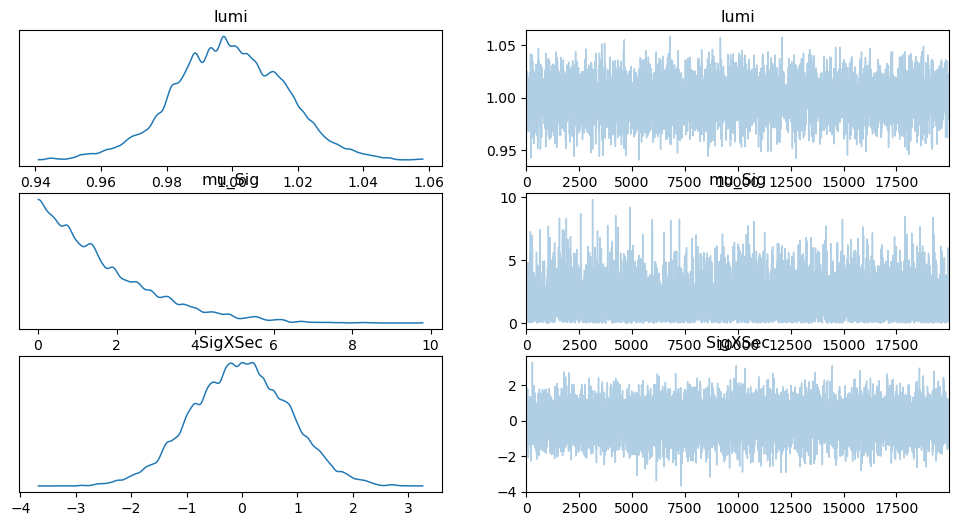

In [10]:
arviz.plot_trace(post_data, var_names=['lumi', 'mu_Sig', 'SigXSec'])

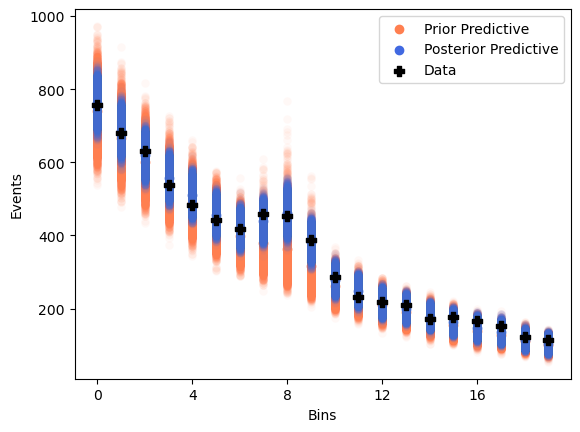

In [35]:
plotting.prior_posterior_predictives(model=model, data=observations, post_pred=post_pred, prior_pred=prior_pred, bin_steps=4)


In [36]:
a = corner.corner(post_data.posterior, var_names=['lumi', 'mu_Sig', 'SigXSec'], quantiles=[0.5], color = 'royalblue');
corner.corner(prior_pred.prior, var_names=['lumi', 'mu_Sig', 'SigXSec'], quantiles=[0.5], color = 'coral', fig = a);

import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color='royalblue', label='Posterior')),
            (mlines.Line2D([], [], color='coral', label='Prior'))
        ], loc="upper right", fontsize=14)

KeyError: 'var names: "[\'lumi\' \'mu_Sig\' \'SigXSec\'] are not present" in dataset'

## Example 2: Toy $\gamma \gamma$ to Higgs

In [26]:
with open(f'workspaces/GammaGammaHiggs.json') as serialized:
    workspace = pyhf.Workspace(json.load(serialized))

model = workspace.model()

observations = workspace.data(model, include_auxdata=False)
observations_inclAux = workspace.data(model)

Frequentist results:

In [27]:
best_fit = pyhf.infer.mle.fit(observations_inclAux, pdf=model)

print(f'MLE for mu: {best_fit[model.config.poi_index]}')

MLE for mu: 1.0755664000067255


Bayesian results:

In [28]:
unconstr_priors = {
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [1], 'beta': [3]}
}

In [29]:
n_draws = 10_000

with infer.model(model, unconstr_priors, observations):
    post_data = pymc.sample(draws=n_draws, chains=1)
    post_pred = pymc.sample_posterior_predictive(post_data)

    prior_pred = pymc.sample_prior_predictive(n_draws)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, NormUncertainty]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, NormUncertainty, mu]


In [42]:
model.config.par_names

['mu', 'NormUncertainty']

In [40]:
print(f'Posterior mean for mu: {np.array(post_data.posterior.mu[0]).mean()}')

Posterior mean for mu: 1.0238040766327339


array([[<Axes: title={'center': 'NormUncertainty'}>,
        <Axes: title={'center': 'NormUncertainty'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

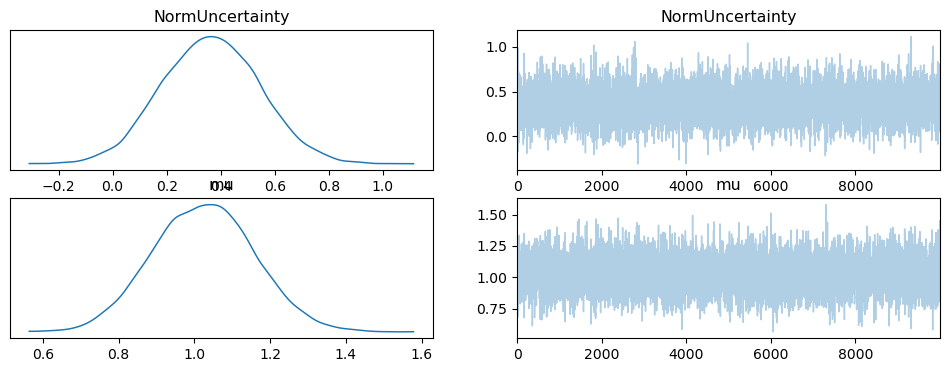

In [41]:
arviz.plot_trace(post_data)

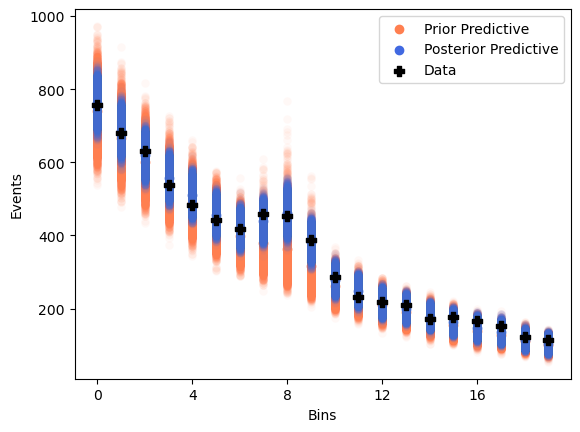

In [37]:
plotting.prior_posterior_predictives(model=model, data=observations, post_pred=post_pred, prior_pred=prior_pred, bin_steps=4)

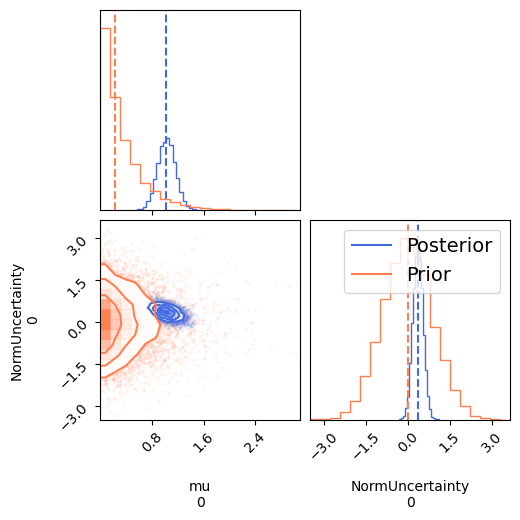

In [43]:
a = corner.corner(post_data.posterior, var_names=model.config.par_names, quantiles=[0.5], color = 'royalblue');
corner.corner(prior_pred.prior, var_names=model.config.par_names,quantiles=[0.5], color = 'coral', fig = a);

import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color='royalblue', label='Posterior')),
            (mlines.Line2D([], [], color='coral', label='Prior'))
        ], loc="upper right", fontsize=14)